# 유사 음원 찾기
### 데이터셋 구성
* 원곡과 표절, 표절의혹, 샘플링, 리메이크 음원 각각 선정 => 총 14곡(Test 데이터)
* 아마추어 작곡가들이 만든 2분 이내의 음원(출처 : 사이디라이트) => 총 2322곡

### 진행 방안
* 음원 특성 추출 후 음원간 유사도 측정 및 비교
* Test 데이터 내 유사곡들의 유사도 Score를 정의
* 다양한 특성 추출 및 분석 방법론 적용 케이스별 유사도 Score 개선여부 테스트

### 음원 특성 추출 및 유사도 비교
### &nbsp; Part 1. 유클리드 거리, 코사인 유사도, 피어슨 유사도
* 음원별 특성 추출 후, 벡터간 유사도 측정
* 추출 특성 => Tempo 1개, Chroma 72개, MFCC 39개

### &nbsp; Part 2. K-Means, DBSCAN

### &nbsp; Part 3. Mel Spectrogram 기반 딥러닝 활용

### 종합

---

In [421]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from matplotlib import rc

# rc('font', family='Arial Unicode MS')

warnings.filterwarnings(action='ignore')

In [2]:
DIR_PATH = "/content/drive/MyDrive/ds_study/DL_project2/"

SAMPLING_RATE = 44100

TEST_MUSIC = 14 # Test 데이터 Music 총 개수
SAMPLE_MUSIC = 500 # 비교용 샘플 Music 랜덤 추출 개수

START_INDEX = 0 # 데이터프레임에서 조회할 음원 index 기본 범위 설정
END_INDEX = 9999 # 데이터프레임에서 조회할 음원 index 기본 범위 설정

#### mp3파일 경로 데이터프레임 생성

In [ ]:
# music_paths = glob.glob(DIR_PATH + "data/*.mp3")
# music_paths[:5]

In [ ]:
# total_music_paths = pd.DataFrame(music_paths, columns=["Path"])
# total_music_paths.head()

In [ ]:
# total_music_paths.to_csv(DIR_PATH + 'music_paths.csv', index=False) # csv 파일로 저장

In [3]:
total_music_paths = pd.read_csv(DIR_PATH + 'music_paths.csv')
total_music_paths.head()

,Path
0,/content/drive/MyDrive/ds_study/DL_project2/da...
1,/content/drive/MyDrive/ds_study/DL_project2/da...
2,/content/drive/MyDrive/ds_study/DL_project2/da...
3,/content/drive/MyDrive/ds_study/DL_project2/da...
4,/content/drive/MyDrive/ds_study/DL_project2/da...


In [4]:
total_music_paths.shape

(2341, 1)

# 음원 특성 관련 Chroma 시각화 및 검토

In [5]:
import librosa
import librosa.display
import IPython.display as ipd

In [6]:
# chromagram 시각화 함수 정의 => 'stft', 'cqt', 'cens' 옵션별 출력
def show_chromagram(music, sr, type='stft'):
  if type == 'cqt':
    chroma = librosa.feature.chroma_cqt(music, sr)
  elif type == 'cens':
    chroma = librosa.feature.chroma_cens(music, sr)
  elif type == 'stft':
    chroma = librosa.feature.chroma_stft(music, sr)
  else:
    print('type error')
    return

  seconds = len(music)/SAMPLING_RATE

  plt.figure(figsize=(15,5))
  librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
  plt.colorbar()
  plt.tight_layout()
  plt.xlabel('time')
  plt.ylabel('pitch class')
  plt.xticks(np.arange(0, seconds, seconds//10)) # 좌표간격 설정
  plt.show()

In [7]:
# 테스트용 음원 load
music, sr = librosa.load(total_music_paths.loc[0, 'Path'], sr=SAMPLING_RATE, duration=None)

#### chroma_stft

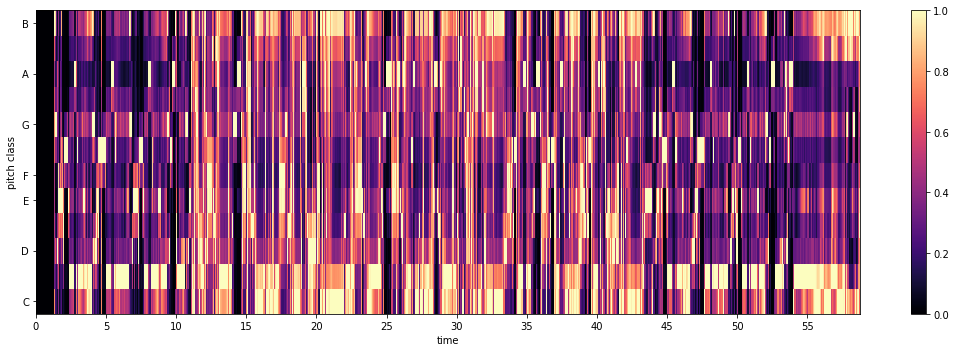

In [8]:
show_chromagram(music, sr, 'stft')

#### chroma_cqt

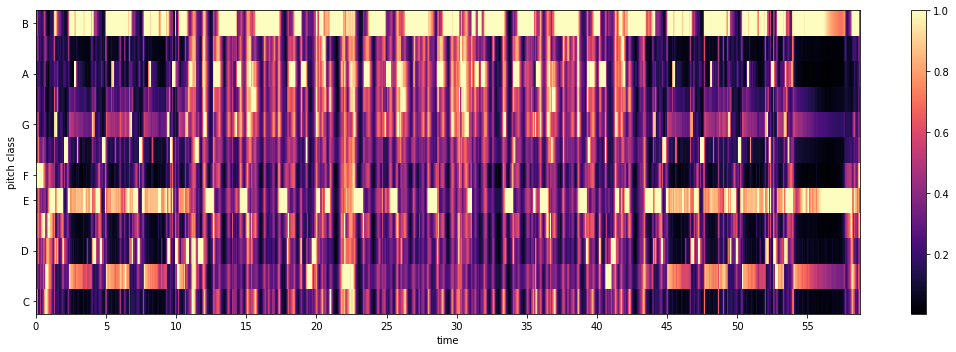

In [9]:
show_chromagram(music, sr, 'cqt')

#### chroma_cens

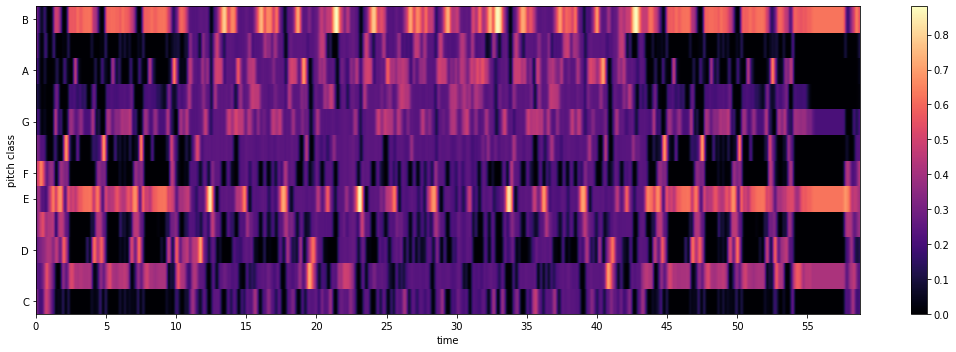

In [10]:
show_chromagram(music, sr, 'cens')

> 12음계를 기반으로 위 3가지가 각각의 음원 특성을 나타내는 것을 확인함

# 데이터셋 구성

In [11]:
# 원곡 및 유사곡 위주의 Test 데이터 파일정보 생성
test_data = pd.read_excel(DIR_PATH + 'test_data/test_data_list.xlsx', index_col=0)
test_data

,Music,Path
1,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...
2,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...
3,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...
4,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...
5,요시마타 료 - Resolver,/content/drive/MyDrive/ds_study/DL_project2/te...
6,FTISLAND - 사랑앓이,/content/drive/MyDrive/ds_study/DL_project2/te...
7,TLC - No Scrubs,/content/drive/MyDrive/ds_study/DL_project2/te...
8,Ed Sheeran - Shape of you,/content/drive/MyDrive/ds_study/DL_project2/te...
9,Harold Faltermeyer - Axel F,/content/drive/MyDrive/ds_study/DL_project2/te...
10,싸이 - 챔피언,/content/drive/MyDrive/ds_study/DL_project2/te...


In [12]:
# 샘플 Music 랜덤 추출
random.seed(42)

sample_index = random.sample(range(len(total_music_paths)), SAMPLE_MUSIC) # SAMPLE_MUSIC : 추출 개수
sample_index.sort()

sample_music = total_music_paths.loc[sample_index, :]
sample_music["Music"] = [f'Music_{idx}' for idx in sample_music.index]
sample_music = sample_music[['Music', 'Path']]
sample_music.head()

,Music,Path
2,Music_2,/content/drive/MyDrive/ds_study/DL_project2/da...
3,Music_3,/content/drive/MyDrive/ds_study/DL_project2/da...
7,Music_7,/content/drive/MyDrive/ds_study/DL_project2/da...
8,Music_8,/content/drive/MyDrive/ds_study/DL_project2/da...
13,Music_13,/content/drive/MyDrive/ds_study/DL_project2/da...


#### Total 데이터프레임 생성 => "df_total_v0"

In [13]:
# Test 데이터 및 샘플 Music 합치기 => Total 데이터 "df_total_v0" 생성
df_total_v0 = pd.concat([test_data, sample_music])
df_total_v0.reset_index(drop=True, inplace=True)
df_total_v0.head()

,Music,Path
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...
4,요시마타 료 - Resolver,/content/drive/MyDrive/ds_study/DL_project2/te...


In [14]:
df_total_v0.tail()

,Music,Path
509,Music_2323,/content/drive/MyDrive/ds_study/DL_project2/da...
510,Music_2325,/content/drive/MyDrive/ds_study/DL_project2/da...
511,Music_2331,/content/drive/MyDrive/ds_study/DL_project2/da...
512,Music_2335,/content/drive/MyDrive/ds_study/DL_project2/da...
513,Music_2340,/content/drive/MyDrive/ds_study/DL_project2/da...


# Part 1. 유클리드 거리, 코사인 유사도, 피어슨 유사도

## 음원 특성 추출 및 유사도 비교(1차)
* 추출 특성 : Tempo 1개, Chroma 72개
* 유사도 기준 : 유클리드 거리, 코사인 유사도, 피어슨 유사도

## 음원 특성 추출

In [15]:
# 음원 특성 추출 함수 정의(v1)
def get_features_v1(df, duration=None, offset=0.0, start_idx=START_INDEX, end_idx=END_INDEX):
  df_copy = df.copy() # 데이터프레임 복사본 생성

  for idx, row in tqdm(df_copy.iterrows()):
    # index 범위 확인
    if idx < start_idx or idx > end_idx:
      continue

    # 음원 load
    music_path = row['Path']
    music, sr = librosa.load(music_path, sr=SAMPLING_RATE, duration=duration, offset=offset) # 옵션값 기준 구간 설정

    # 템포 저장
    df_copy.loc[idx, 'Tempo'] = librosa.beat.tempo(music, sr=sr)

    # # zero_crossings 저장 => 적용 제외
    # df_copy.loc[idx, 'Zero_crossings'] = sum(librosa.zero_crossings(music, pad=False))

    # chroma_stft 12음계별 평균 및 분산 산출 후 저장
    chroma_stft_raw = librosa.feature.chroma_stft(music, sr)
    for i, values in enumerate(chroma_stft_raw):
      df_copy.loc[idx, f'Chroma_stft{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'Chroma_stft{i+1}_var'] = values.var() # 분산
    
    # chroma_cqt 12음계별 평균 및 분산 산출 후 저장
    chroma_cqt_raw = librosa.feature.chroma_cqt(music, sr)
    for i, values in enumerate(chroma_cqt_raw):
      df_copy.loc[idx, f'Chroma_cqt{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'Chroma_cqt{i+1}_var'] = values.var() # 분산
    
    # chroma_cens 12음계별 평균 및 분산 산출 후 저장
    chroma_cens_raw = librosa.feature.chroma_cens(music, sr)
    for i, values in enumerate(chroma_cens_raw):
      df_copy.loc[idx, f'Chroma_cens{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'Chroma_cens{i+1}_var'] = values.var() # 분산
  
  return df_copy

In [16]:
# 전체 컬럼 스케일링 함수 정의
def get_norm(df, type='mms', start_col='Tempo'):
  df_copy = df.copy()

  if type == 'mms':
    scaler = MinMaxScaler()
  elif type == 'ss':
    scaler = StandardScaler()
  else:
    print('type error')
    return

  df_copy.loc[:, start_col:] = scaler.fit_transform(df_copy.loc[:, start_col:])
  
  return df_copy

#### 음원 특성 추출 결과 저장 => "df_total_v1"

In [ ]:
df_total_v1 = get_features_v1(df_total_v0)

0it [00:00, ?it/s]

In [ ]:
df_total_v1.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,0.041231,0.499511,0.069588,0.420015,0.065681,0.463250,0.049916,0.582027,0.075694,0.376777,0.040850,0.281621,0.018584,0.200288,0.009001,0.321092,0.023422,0.302838,0.029530,0.186214,0.007784,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,0.047782,0.400804,0.060420,0.494855,0.077104,0.381062,0.064291,0.463533,0.064680,0.478669,0.087827,0.318101,0.031096,0.294483,0.033099,0.217415,0.018938,0.263781,0.034013,0.170267,0.016763,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,0.046854,0.537298,0.085569,0.526882,0.090841,0.604191,0.086772,0.573082,0.098441,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.456608,0.044852,0.446284,0.051490,0.423495,0.036625,0.455113,0.048801,0.450094,0.040692,0.551862,0.058376,0.512806,0.077958,0.457088,0.053970,0.274985,0.015978,0.353138,0.016573,0.331165,0.020

In [ ]:
df_total_v1.shape

(514, 75)

In [ ]:
df_total_v1.to_csv(DIR_PATH + f'test_data/df_total_v1_{SAMPLE_MUSIC}.csv', index=False) # csv 파일로 저장

In [17]:
df_total_v1 = pd.read_csv(DIR_PATH + f'test_data/df_total_v1_{SAMPLE_MUSIC}.csv') # csv 파일 불러오기
df_total_v1.shape

(514, 75)

In [18]:
df_total_v1.head(20) # 특성 추출 결과 확인

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,0.041231,0.499511,0.069588,0.420015,0.065681,0.463250,0.049916,0.582027,0.075694,0.376777,0.040850,0.281621,0.018584,0.200288,0.009001,0.321092,0.023422,0.302838,0.029530,0.186214,0.007784,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,0.047782,0.400804,0.060420,0.494855,0.077104,0.381062,0.064291,0.463533,0.064680,0.478669,0.087827,0.318101,0.031096,0.294483,0.033099,0.217415,0.018938,0.263781,0.034013,0.170267,0.016763,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,0.046854,0.537298,0.085569,0.526882,0.090841,0.604191,0.086772,0.573082,0.098441,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.456608,0.044852,0.446284,0.051490,0.423495,0.036625,0.455113,0.048801,0.450094,0.040692,0.551862,0.058376,0.512806,0.077958,0.457088,0.053970,0.274985,0.015978,0.353138,0.016573,0.331165,0.020

#### 전체 컬럼 스케일링 => "df_total_v1_norm"

In [49]:
df_total_v1_norm = get_norm(df_total_v1, 'ss', start_col='Tempo') # MinMax 스케일링 or Standard 스케일링
df_total_v1_norm.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,-1.190191,-0.545853,0.082530,-0.635227,-0.252936,-0.109665,0.482027,-0.324139,0.794185,-0.821239,-0.405614,0.110159,0.703635,-0.457056,0.014023,-0.894842,0.051307,-0.797827,0.135496,-0.173366,-0.125651,1.047904,1.320460,-0.316873,-0.552658,0.613591,0.037598,0.235069,-0.288019,1.102265,0.268457,1.343021,0.991804,-0.263991,-0.748596,1.001893,0.121039,-0.087411,-0.715214,0.356415,-0.143529,0.302787,0.191176,0.316117,-0.704042,1.624800,0.470653,-0.000724,-0.755876,0.353702,-0.466890,-0.052748,-0.671406,0.796198,-0.177490,1.098438,0.593652,-0.589962,-0.955638,0.846089,-0.309076,-0.302626,-0.948058,0.078063,-0.478879,-0.000991,-0.033618,0.161449,-0.939699,1.485885,-0.111082,-0.234087,-0.956463
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,-1.116211,-1.089378,0.489764,-1.250611,0.417578,-1.492630,-0.017524,-1.182348,1.212017,-1.350539,0.282957,-1.484320,-0.100082,-1.537669,-0.039306,-1.048583,0.390414,0.282349,2.077205,-0.083872,0.705013,-0.214617,1.572272,-0.729489,0.862527,0.936348,1.306524,1.210692,2.191432,0.045137,0.184486,0.746677,0.941285,-0.544607,-0.610315,-0.398728,-0.330119,-0.517099,-0.490874,-0.309720,-0.446625,0.861303,0.575302,-0.258486,-0.245838,0.745479,0.134044,0.793708,0.760634,0.731352,0.131174,1.051387,0.981856,-0.288063,-0.416083,0.650998,0.865138,-0.754919,-0.425447,-0.574921,-0.210841,-0.835247,-0.406501,-0.395825,-0.465432,1.036034,0.610927,-0.446997,0.266027,0.895652,-0.077144,0.597501,-0.068662
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,-0.876866,-0.653607,0.108749,-0.881053,0.048207,-0.751697,0.450900,-1.221297,-0.439152,-0.661098,0.515297,-0.336726,0.663683,-0.970881,-0.422306,-0.792368,0.888719,-0.595392,0.375240,-0.086752,1.279661,-0.416760,1.089873,-0.698190,-0.018122,0.655776,0.723737,0.092642,-0.115756,0.144175,-0.083200,-0.322988,-0.690887,0.093665,-0.414783,0.381534,-0.592314,-0.047037,-0.522653,0.611427,0.384854,1.100315,1.037264,1.301480,0.470707,1.558421,1.165905,0.121721,-0.588072,0.291490,0.162747,-0.194478,-0.336727,-0.024014,-0.095272,-0.699663,-0.537159,-0.039842,-0.429931,0.418948,-0.429021,-0.357441,-0.905125,0.315330,-0.379937,0.838883,-0.313273,1.104899,-0.255293,1.227644,1.014521,-0.174131,-0.854338
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,-0.701021,-1.121944,0.267865,-0.861013,0.722036,-0.722165,0.910910,-0.913179,0.732724,-1.220337,-0.037543,-0.829265,0.300959,-0.908058,0.094375,-0.850683,0.986353,-0.566954,0.837059,-0.175713,1.397769,-0.430050,1.563883,-1.010613,0.704056,0.713740,-0.290123,1.992987,0.407065,1.381116,0.060384,0.743422,-0.284309,0.259588,-0.710695,0.261295,-0.507661,0.224388,-0.872951,0.056795

## 음원별 유사도 측정 및 비교(v1)

In [21]:
# 유클리드 거리 산출 함수 정의
def euclidean_dist(a, b):
  return np.sqrt(np.sum((a - b)**2))

# 코사인 유사도 산출 함수 정의
def cos_similarity(a, b):
  return np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b))

# 피어슨 유사도 산출 함수 정의
def pearson_similarity(a, b):
  return np.dot((a - np.mean(a)), (b - np.mean(b)))/(np.linalg.norm(a - np.mean(a)) * np.linalg.norm(b - np.mean(b)))

In [22]:
# 원곡음원과 유사음원간 유사도 측정 함수 정의
def get_similarity_A(df_norm, start_col='Tempo'):
  # "score_table_a" 생성
  score_table_a = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)

  for idx, row in score_table_a.iterrows():
    if score_table_a.index[0] != 1: # index 1로 시작하는지 확인
      print('check index')
      return

    # 스케일링 적용된 데이터 기준 값 추출
    a = df_norm.loc[idx*2-2, start_col:].values
    b = df_norm.loc[idx*2-1, start_col:].values

    # 컬럼별 값 추가
    score_table_a.loc[idx, 'Euclidean'] = euclidean_dist(a, b)
    score_table_a.loc[idx, 'Cos_sim'] = cos_similarity(a, b)
    score_table_a.loc[idx, 'Pearson_sim'] = pearson_similarity(a, b)
  
  return score_table_a

In [23]:
# 원곡음원과 샘플음원(랜덤추출)간 유사도 측정 함수 정의
def get_similarity_B(df_norm, start_col='Tempo'):
  # "score_table_b" 생성
  score_table_b = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
  score_table_b.drop(['구분'], axis=1, inplace=True)
  score_table_b['비교곡'] = f'샘플 Music {SAMPLE_MUSIC}곡'

  for idx, row in score_table_b.iterrows():
    if score_table_b.index[0] != 1: # index 1로 시작하는지 확인
      print('check index')
      return

    # 스케일링 적용된 데이터 기준 추출
    a = df_norm.loc[idx*2-2, start_col:].values

    # 샘플 Music들과 각각 비교 후 평균값 산출
    euclidean_dist_list = []
    cos_similarity_list = []
    pearson_similarity_list = []
    for i in range(SAMPLE_MUSIC):
      samplt_idx = df_norm.index[i+TEST_MUSIC] # Test 데이터 개수(TEST_MUSIC)만큼 조정
      b = df_norm.loc[samplt_idx, start_col:].values

      euclidean_dist_list.append(euclidean_dist(a, b))
      cos_similarity_list.append(cos_similarity(a, b))
      pearson_similarity_list.append(pearson_similarity(a, b))

    # 컬럼별 값 추가
    score_table_b.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
    score_table_b.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
    score_table_b.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)
  
  return score_table_b

#### 원곡음원과 유사음원간 비교 => "score_table_1a"

In [220]:
# 원곡음원과 유사음원간 비교 결과
score_table_1a = get_similarity_A(df_total_v1_norm, start_col='Tempo')
score_table_1a

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,7.174611,0.377261,0.377643
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,5.436904,0.602145,0.602041
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,5.395231,0.442581,0.451580
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,9.055185,0.232390,0.241405
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,5.253037,0.730301,0.737535
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,6.346246,0.305314,0.290058
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,3.472009,0.876138,0.876536


#### 원곡음원과 샘플음원(랜덤추출)간 비교 => "score_table_1b"

In [221]:
# 원곡음원과 샘플음원(랜덤추출)간 비교 결과
score_table_1b = get_similarity_B(df_total_v1_norm, start_col='Tempo')
score_table_1b

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,샘플 Music 500곡,9.981644,0.008141,0.008252
2,와이낫 - 파랑새,샘플 Music 500곡,10.045391,0.006847,0.006527
3,요시마타 료 - Resolver,샘플 Music 500곡,9.137197,-0.003864,-0.001026
4,TLC - No Scrubs,샘플 Music 500곡,10.828753,0.007368,0.004334
5,Harold Faltermeyer - Axel F,샘플 Music 500곡,10.961216,0.006214,0.000583
6,A$ton Wyld - Next Level,샘플 Music 500곡,9.962586,0.013065,0.010294
7,S.E.S. - Dreams Come True,샘플 Music 500곡,10.984249,0.013358,0.013944


## Score 산출 => "score_table_result_1ab"
* Euclidean 점수 : 샘플음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
* Cos_sim 점수 : 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
* Pearson_sim 점수 : 샘플음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)

In [60]:
# Score 산출 함수 정의
def get_score_result(df_a, df_compare, rate=False):
  score_table_result = df_a.copy()

  if rate == True:
    # Euclidean 점수 => 비교대상음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
    score_table_result['Euclidean'] = round(((df_compare['Euclidean'] - score_table_result['Euclidean']) / df_compare['Euclidean']) * 100, 2)

    # Cos_sim 점수 => 비교대상음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
    score_table_result['Cos_sim'] = round(((score_table_result['Cos_sim'] - df_compare['Cos_sim']) / np.abs(df_compare['Cos_sim'])) * 100, 2)

    # Pearson_sim 점수 => 비교대상음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
    score_table_result['Pearson_sim'] = round(((score_table_result['Pearson_sim'] - df_compare['Pearson_sim']) / np.abs(df_compare['Pearson_sim'])) * 100, 2)
  else:
    # Euclidean 점수 => 비교대상음원 대비 유사음원과 비교 시, (-) 변화량 값
    score_table_result['Euclidean'] = df_compare['Euclidean'] - score_table_result['Euclidean']

    # Cos_sim 점수 => 비교대상음원 대비 유사음원과 비교 시, (+) 변화량 값
    score_table_result['Cos_sim'] = score_table_result['Cos_sim'] - df_compare['Cos_sim']

    # Pearson_sim 점수 => 비교대상음원 대비 유사음원과 비교 시, (+) 변화량 값
    score_table_result['Pearson_sim'] = score_table_result['Pearson_sim'] - df_compare['Pearson_sim']

  if rate == True:
    # Score 산출 => 3개 점수의 평균
    score_table_result["Score"] = round((score_table_result['Euclidean'] + score_table_result['Cos_sim'] + score_table_result['Pearson_sim']) / 3, 2)
  else:
    # Score 산출 => 3개 점수의 평균 * 100
    score_table_result["Score"] = round((score_table_result['Euclidean'] + score_table_result['Cos_sim'] + score_table_result['Pearson_sim']) / 3, 4)
    score_table_result["Score"] *= 100

  return score_table_result

In [224]:
# Score 산출 결과 확인
score_table_result_1ab = get_score_result(score_table_1a, score_table_1b, rate=False) # 1a 기준으로 1b와 비교
score_table_result_1ab

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,2.807033,0.369121,0.369392,118.18
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,4.608487,0.595298,0.595514,193.31
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,3.741966,0.446446,0.452606,154.70
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,1.773569,0.225022,0.237071,74.52
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,5.708178,0.724086,0.736952,238.97
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,3.616340,0.292249,0.279764,139.61
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,7.512240,0.862780,0.862592,307.92


In [225]:
score_table_result_1ab_mean = score_table_result_1ab["Score"].mean() # Score 평균 확인
score_table_result_1ab_mean

175.31571428571428

#### 원곡음원과 Test음원(12곡)간 비교 => "score_table_1c"

In [33]:
# 원곡음원과 Test음원(12곡)간 유사도 측정 함수 정의
def get_similarity_C(df_norm, start_col='Tempo'):
  # "score_table_c" 생성
  score_table_c = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
  score_table_c.drop(['구분'], axis=1, inplace=True)
  score_table_c['비교곡'] = f'다른 Test음원 {TEST_MUSIC - 2}곡'

  for idx, row in score_table_c.iterrows():
    if score_table_c.index[0] != 1: # index 1로 시작하는지 확인
      print('check index')
      return

    # 스케일링 적용된 데이터 기준 추출
    a = df_norm.loc[idx*2-2, start_col:].values

    # Test음원(12곡)들과 각각 비교 후 평균값 산출
    euclidean_dist_list = []
    cos_similarity_list = []
    pearson_similarity_list = []
    for i in range(TEST_MUSIC-2):
      samplt_idx = df_norm.index[(idx*2+i)%TEST_MUSIC] # Test 음원(14곡) 중 유사음원이 아닌 12곡과 비교
      b = df_norm.loc[samplt_idx, start_col:].values

      euclidean_dist_list.append(euclidean_dist(a, b))
      cos_similarity_list.append(cos_similarity(a, b))
      pearson_similarity_list.append(pearson_similarity(a, b))

    # 컬럼별 값 추가
    score_table_c.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
    score_table_c.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
    score_table_c.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)
  
  return score_table_c

In [226]:
score_table_1a # 원곡음원과 유사음원간 비교 결과

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,7.174611,0.377261,0.377643
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,5.436904,0.602145,0.602041
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,5.395231,0.442581,0.451580
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,9.055185,0.232390,0.241405
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,5.253037,0.730301,0.737535
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,6.346246,0.305314,0.290058
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,3.472009,0.876138,0.876536


In [227]:
# 원곡음원과 Test음원(12곡)간 비교 결과
score_table_1c = get_similarity_C(df_total_v1_norm, start_col='Tempo')
score_table_1c

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,다른 Test음원 12곡,6.786353,0.325200,0.326982
2,와이낫 - 파랑새,다른 Test음원 12곡,6.711555,0.350231,0.350023
3,요시마타 료 - Resolver,다른 Test음원 12곡,7.537910,-0.020101,-0.010920
4,TLC - No Scrubs,다른 Test음원 12곡,7.857563,0.255188,0.251070
5,Harold Faltermeyer - Axel F,다른 Test음원 12곡,8.141975,0.233274,0.233134
6,A$ton Wyld - Next Level,다른 Test음원 12곡,7.356070,0.236307,0.233782
7,S.E.S. - Dreams Come True,다른 Test음원 12곡,7.432379,0.379355,0.381293


## Score 산출 => "score_table_result_1ac"

In [228]:
# Score 산출 결과 확인
score_table_result_1ac = get_score_result(score_table_1a, score_table_1c, rate=False) # 1a 기준으로 1c와 비교
score_table_result_1ac

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,-0.388258,0.052062,0.050661,-9.52
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,1.274652,0.251913,0.252019,59.29
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,2.142679,0.462682,0.462500,102.26
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,-1.197621,-0.022798,-0.009665,-41.00
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,2.888938,0.497026,0.504401,129.68
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,1.009824,0.069007,0.056276,37.84
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,3.960370,0.496783,0.495242,165.08


In [229]:
score_table_result_1ac_mean = score_table_result_1ac["Score"].mean() # Score 평균 확인
score_table_result_1ac_mean

63.37571428571429

> 샘플음원 비교 시 Score와 상당히 차이가 남을 확인함 (샘플음원 비교 시 Score 평균 : 175.32)<br/>
> 특히 2곡은 마이너스 Score인 것으로 확인됨 => 유사음원으로 설정한 음원과의 유사도가 평균치보다도 오히려 낮게 나온 것을 의미함

## (참고)유사음원의 전체가 아닌 특정구간(가장 유사한 구간)을 추출해 비교 및 결과 확인
\- 테스트 음원 => "더더 - It’s you" & "MC몽 - 너에게 쓰는 편지"

In [41]:
# "더더 - It’s you" 특정구간 추출 및 확인
music_test1, sr_test1 = librosa.load(test_data.loc[1, 'Path'], sr=SAMPLING_RATE, duration=30, offset=45)
ipd.Audio(music_test1, rate=sr_test1)

Output hidden; open in https://colab.research.google.com to view.

In [42]:
# "MC몽 - 너에게 쓰는 편지" 특정구간 추출 및 확인
music_test2, sr_test2 = librosa.load(test_data.loc[2, 'Path'], sr=SAMPLING_RATE, duration=30, offset=45)
ipd.Audio(music_test2, rate=sr_test2)

Output hidden; open in https://colab.research.google.com to view.

#### 테스트를 위해 기존 데이터프레임 복사 => "df_total_v1_1"

In [67]:
df_total_v1_1 = df_total_v1.copy()
df_total_v1_1.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,0.041231,0.499511,0.069588,0.420015,0.065681,0.463250,0.049916,0.582027,0.075694,0.376777,0.040850,0.281621,0.018584,0.200288,0.009001,0.321092,0.023422,0.302838,0.029530,0.186214,0.007784,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,0.047782,0.400804,0.060420,0.494855,0.077104,0.381062,0.064291,0.463533,0.064680,0.478669,0.087827,0.318101,0.031096,0.294483,0.033099,0.217415,0.018938,0.263781,0.034013,0.170267,0.016763,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,0.046854,0.537298,0.085569,0.526882,0.090841,0.604191,0.086772,0.573082,0.098441,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.456608,0.044852,0.446284,0.051490,0.423495,0.036625,0.455113,0.048801,0.450094,0.040692,0.551862,0.058376,0.512806,0.077958,0.457088,0.053970,0.274985,0.015978,0.353138,0.016573,0.331165,0.020

In [68]:
df_total_v1_1 = get_features_v1(df_total_v1_1, duration=30, offset=45, start_idx=0, end_idx=1) # 특정구간(45초에서 시작, 길이 30초) 기준으로 index 0과 1만 특성을 새로 추출함
df_total_v1_1.head()

0it [00:00, ?it/s]

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.414549,0.095518,0.372421,0.065435,0.445976,0.090739,0.366985,0.080209,0.367018,0.071556,0.455834,0.094319,0.349766,0.065868,0.370435,0.082652,0.391650,0.077820,0.517299,0.077926,0.608144,0.109329,0.392308,0.055491,0.529037,0.073359,0.415181,0.043308,0.563224,0.076023,0.578266,0.080991,0.384019,0.032224,0.531796,0.064604,0.395993,0.029429,0.540013,0.064277,0.483184,0.072102,0.488851,0.044406,0.591852,0.063177,0.388910,0.028193,0.286157,0.015810,0.203588,0.008542,0.292512,0.016502,0.311834,0.028817,0.185983,0.005000,0.289144,0.012846,0.209846,0.003565,0.296565,0.015455,0.250657,0.022694,0.265244,0.007031,0.340048,0.012073,0.205907,0.004133
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.388484,0.104921,0.321189,0.077756,0.293285,0.065026,0.336297,0.094175,0.293445,0.071856,0.285705,0.076829,0.290001,0.061952,0.419708,0.089068,0.564774,0.120858,0.481180,0.080347,0.526450,0.122507,0.421533,0.085551,0.627022,0.115229,0.492094,0.102954,0.395016,0.060987,0.485073,0.090253,0.271911,0.027962,0.358253,0.049940,0.292662,0.042444,0.437580,0.057885,0.516371,0.084706,0.286375,0.025030,0.566133,0.080084,0.435007,0.068614,0.378550,0.030071,0.277627,0.024464,0.192639,0.009443,0.269197,0.028358,0.112308,0.006266,0.196900,0.021690,0.128778,0.013084,0.266105,0.022073,0.306772,0.031507,0.131056,0.010904,0.352611,0.030543,0.234902,0.012067
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,0.046854,0.537298,0.085569,0.526882,0.090841,0.604191,0.086772,0.573082,0.098441,0.392481,0.046048,0.275612,0.031757,0.188197,0.013879,0.242663,0.024967,0.145882,0.010859,0.239395,0.016687,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.456608,0.044852,0.446284,0.051490,0.423495,0.036625,0.455113,0.048801,0.450094,0.040692,0.551862,0.058376,0.512806,0.077958,0.457088,0.053970,0.274985,0.015978,0.353138,0.016573,0.331165,0.020

In [69]:
# 스케일링 적용 => "df_total_v1_1_norm"
df_total_v1_1_norm = get_norm(df_total_v1_1, 'ss', start_col='Tempo')
df_total_v1_1_norm.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,Chroma_cqt7_var,Chroma_cqt8_mean,Chroma_cqt8_var,Chroma_cqt9_mean,Chroma_cqt9_var,Chroma_cqt10_mean,Chroma_cqt10_var,Chroma_cqt11_mean,Chroma_cqt11_var,Chroma_cqt12_mean,Chroma_cqt12_var,Chroma_cens1_mean,Chroma_cens1_var,Chroma_cens2_mean,Chroma_cens2_var,Chroma_cens3_mean,Chroma_cens3_var,Chroma_cens4_mean,Chroma_cens4_var,Chroma_cens5_mean,Chroma_cens5_var,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,-1.190191,-0.862897,0.234503,-1.026460,-0.443251,-0.580170,0.277421,-1.231706,0.076975,-1.265711,-0.649024,-0.400658,0.313230,-1.131428,-0.288507,-1.143714,0.186894,-0.841277,0.255342,0.150136,-0.168512,1.028867,1.661584,-0.964727,-1.073921,0.708992,-0.058477,0.339014,-0.474287,0.969723,0.114319,1.519787,0.758473,-0.236136,-1.111765,0.850633,-0.138077,0.022161,-1.117181,0.628625,-0.318565,0.772370,0.405991,0.495596,-0.874814,1.692865,0.087920,0.094389,-1.162216,0.398830,-0.599064,-0.013762,-0.702214,0.498477,-0.543539,1.200803,0.551450,-0.590455,-1.117113,0.600458,-0.607749,-0.151505,-1.140966,0.344387,-0.627106,0.476679,0.214365,0.274756,-1.077694,1.580947,-0.476494,-0.041506,-1.153814
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,-1.116211,-1.064560,0.626400,-1.440731,0.104253,-1.868994,-0.826350,-1.498369,0.718526,-1.855552,-0.636435,-1.760835,-0.401723,-1.670821,-0.468207,-0.690501,0.456742,0.756500,2.235554,-0.166024,-0.061124,0.308124,2.252454,-0.710557,0.350837,1.397625,1.129788,0.916886,1.602923,-0.201429,-0.349919,0.828603,1.063411,-1.002774,-1.248248,-0.344848,-0.550197,-0.738241,-0.671914,-0.062535,-0.529857,1.019837,0.829630,-0.918702,-1.490926,1.502370,0.604608,0.453950,0.142361,1.354057,0.082506,0.854434,0.390920,-0.546183,-0.918853,0.712497,0.523663,-1.351628,-1.042438,-0.360349,-0.173614,-1.112841,-0.489545,0.025480,-0.239936,1.150176,0.797473,-1.167223,-0.854662,1.719437,0.552637,0.299474,-0.680486
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,-0.876866,-0.652783,0.108163,-0.878909,0.049192,-0.748865,0.452648,-1.216194,-0.437460,-0.657578,0.517274,-0.334839,0.665194,-0.967867,-0.420753,-0.792672,0.888248,-0.595906,0.374424,-0.087222,1.281841,-0.417739,1.083968,-0.696411,-0.016100,0.653913,0.724574,0.093065,-0.114473,0.144950,-0.081853,-0.323295,-0.690780,0.094443,-0.412067,0.381844,-0.591263,-0.046806,-0.521028,0.610307,0.385297,1.098221,1.035855,1.301249,0.472356,1.553844,1.165581,0.122249,-0.585943,0.289803,0.163080,-0.194241,-0.335765,-0.022932,-0.093487,-0.699765,-0.536683,-0.038623,-0.427885,0.419236,-0.428402,-0.357029,-0.904162,0.314000,-0.380086,0.837334,-0.314028,1.104780,-0.252599,1.222884,1.013497,-0.173979,-0.852024
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,-0.701021,-1.120940,0.267248,-0.858892,0.723041,-0.719379,0.912421,-0.908758,0.736227,-1.215419,-0.035251,-0.826873,0.302383,-0.905137,0.095776,-0.850994,0.985873,-0.567483,0.835911,-0.176182,1.400005,-0.431029,1.556287,-1.008589,0.705917,0.711809,-0.289711,1.994460,0.409423,1.382177,0.061727,0.742451,-0.284137,0.260253,-0.707440,0.261567,-0.506627,0.224547,-0.871001,0.05577

In [70]:
# 원곡음원과 유사음원간 비교 결과 => "score_table_1_1a"
score_table_1_1a = get_similarity_A(df_total_v1_1_norm, start_col='Tempo')
score_table_1_1a

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,6.802920,0.618944,0.616075
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,5.436267,0.601282,0.601163
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,5.393373,0.442185,0.451228
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,9.050287,0.232509,0.241454
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,5.251423,0.730268,0.737425
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,6.342533,0.305758,0.290348
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,3.470030,0.876002,0.876397


In [71]:
# 원곡음원과 샘플음원(랜덤추출)간 비교 결과 => "score_table_1_1b"
score_table_1_1b = get_similarity_B(df_total_v1_1_norm, start_col='Tempo')
score_table_1_1b

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,샘플 Music 500곡,10.664271,0.004232,0.007668
2,와이낫 - 파랑새,샘플 Music 500곡,10.039318,0.006435,0.006079
3,요시마타 료 - Resolver,샘플 Music 500곡,9.132793,-0.003867,-0.000986
4,TLC - No Scrubs,샘플 Music 500곡,10.823869,0.007099,0.003964
5,Harold Faltermeyer - Axel F,샘플 Music 500곡,10.957239,0.006246,0.000448
6,A$ton Wyld - Next Level,샘플 Music 500곡,9.957444,0.013173,0.010316
7,S.E.S. - Dreams Come True,샘플 Music 500곡,10.978345,0.013002,0.013571


In [73]:
# Score 산출 결과 확인 => "score_table_result_1_1ab"
score_table_result_1_1ab = get_score_result(score_table_1_1a, score_table_1_1b, rate=False)
score_table_result_1_1ab

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,3.861351,0.614712,0.608407,169.48
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,4.603051,0.594847,0.595084,193.10
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,3.739420,0.446052,0.452215,154.59
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,1.773583,0.225409,0.237490,74.55
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,5.705817,0.724022,0.736977,238.89
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,3.614911,0.292585,0.280033,139.58
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,7.508314,0.862999,0.862825,307.80


> 테스트 음원이었던 "더더 - It’s you"와 "MC몽 - 너에게 쓰는 편지"간의 Score가 기존 118.18에서 169.48로 향상됨

In [74]:
# 원곡음원과 Test음원(12곡)간 비교 결과 => "score_table_1_1c"
score_table_1_1c = get_similarity_C(df_total_v1_1_norm, start_col='Tempo')
score_table_1_1c

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,다른 Test음원 12곡,7.223623,0.358015,0.372107
2,와이낫 - 파랑새,다른 Test음원 12곡,6.784427,0.359474,0.360418
3,요시마타 료 - Resolver,다른 Test음원 12곡,7.707758,-0.017726,-0.012132
4,TLC - No Scrubs,다른 Test음원 12곡,7.958246,0.255663,0.256052
5,Harold Faltermeyer - Axel F,다른 Test음원 12곡,8.336572,0.219091,0.226119
6,A$ton Wyld - Next Level,다른 Test음원 12곡,7.562053,0.224863,0.226057
7,S.E.S. - Dreams Come True,다른 Test음원 12곡,7.474035,0.387172,0.389674


In [75]:
# Score 산출 결과 확인 => "score_table_result_1_1ac"
score_table_result_1_1ac = get_score_result(score_table_1_1a, score_table_1_1c, rate=False)
score_table_result_1_1ac

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,0.420704,0.260928,0.243968,30.85
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,1.348160,0.241808,0.240744,61.02
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,2.314386,0.459910,0.463360,107.92
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,-1.092041,-0.023154,-0.014598,-37.66
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,3.085149,0.511177,0.511305,136.92
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,1.219520,0.080895,0.064292,45.49
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,4.004004,0.488830,0.486722,165.99


> 테스트 음원이었던 "더더 - It’s you"와 "MC몽 - 너에게 쓰는 편지"간의 Score가 기존 -9.52에서 30.85로 (+)로 전환되며 향상됨

# 음원 특성 추출 및 유사도 비교(2차)
* 추출 특성 : Tempo 1개, Chroma 72개, MFCC 26개
* 유사도 기준 : 유클리드 거리, 코사인 유사도, 피어슨 유사도

#### MFCC 옵션값에 따른 특성 시각화 및 비교

In [76]:
mfcc_test = librosa.feature.mfcc(music_test1, sr=sr_test1, n_mfcc=13) # n_mfcc 13으로 설정
mfcc_test

array([[-1.16851906e+02, -1.23444771e+02, -1.29546509e+02, ...,
        -1.03461655e+02, -1.22404297e+02, -1.27884254e+02],
       [ 8.39475632e+01,  8.23653412e+01,  7.75186462e+01, ...,
         9.63855896e+01,  9.77073822e+01,  1.09348518e+02],
       [-2.08627319e+01, -2.54470024e+01, -2.85797005e+01, ...,
        -6.41711731e+01, -6.31554489e+01, -6.00511627e+01],
       ...,
       [-8.17093277e+00, -2.70546103e+00,  5.11001110e+00, ...,
         6.35292625e+00,  4.97155809e+00,  3.40894294e+00],
       [ 4.74177003e-02,  6.33914089e+00,  6.70441008e+00, ...,
         2.37547588e+00,  3.38768959e-03, -7.70899534e-01],
       [ 3.40945768e+00, -8.04408550e-01, -4.32019234e+00, ...,
         5.96972418e+00,  2.64016843e+00, -8.07285845e-01]], dtype=float32)

In [77]:
mfcc_test.shape

(13, 2584)

In [78]:
len(mfcc_test)

13

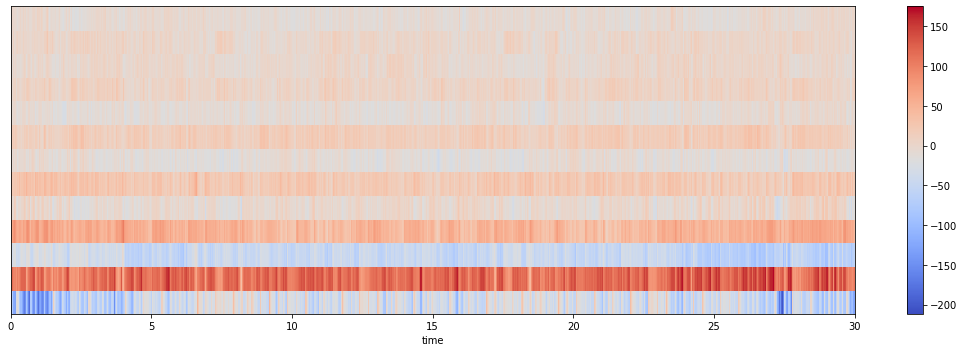

In [ ]:
plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

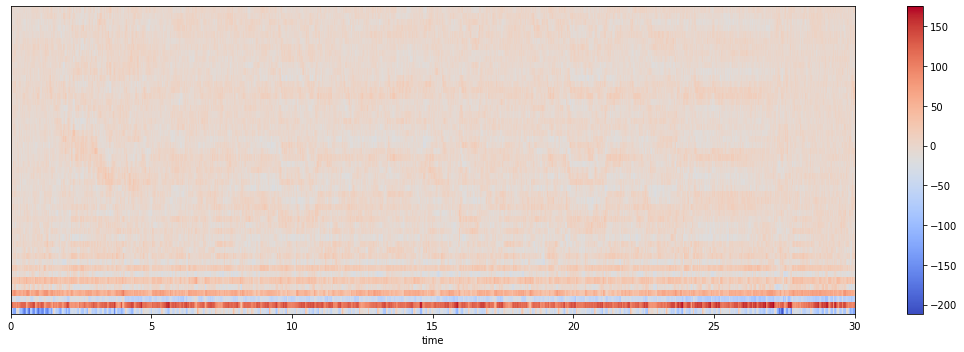

In [ ]:
mfcc_test = librosa.feature.mfcc(music_test1, sr=sr_test1, n_mfcc=50) # n_mfcc 50으로 설정

plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

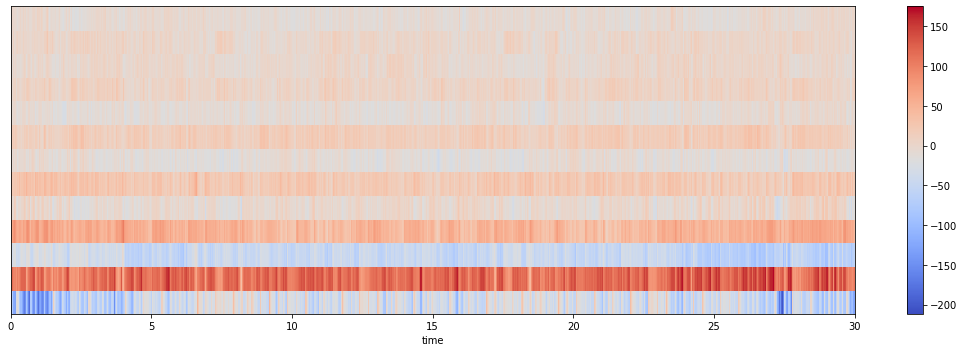

In [ ]:
mfcc_test2 = librosa.feature.mfcc(music_test1, sr=sr_test1, n_mfcc=13) # n_mfcc 13으로 설정

plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test2, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

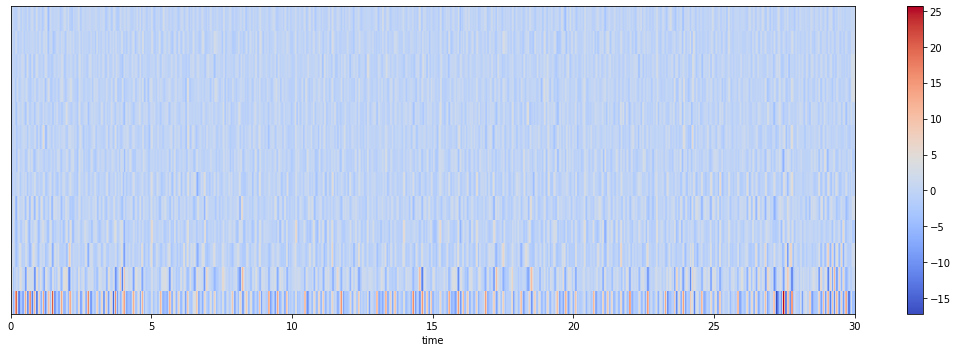

In [ ]:
mfcc_test2_delta = librosa.feature.delta(mfcc_test2)

plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test2_delta, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

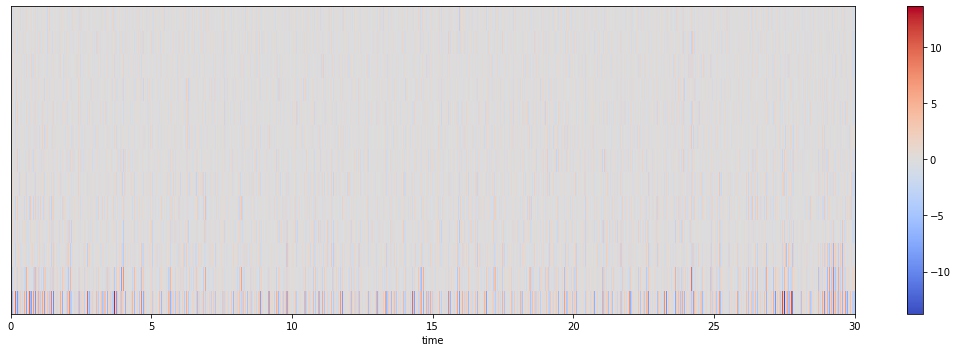

In [ ]:
mfcc_test2_delta2 = librosa.feature.delta(mfcc_test2, order=2)

plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test2_delta2, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

In [ ]:
mfcc_test2.mean(axis=1)

array([-41.303383 , 116.67117  , -47.978    ,  52.246975 ,  -2.46684  ,
        23.92176  , -10.879446 ,  16.62207  ,  -8.112418 ,   6.441608 ,
        -0.8483089,   1.2515312,  -6.8292737], dtype=float32)

In [ ]:
mfcc_test2_delta.mean(axis=1)

array([ 0.01190331,  0.01144092, -0.01259566, -0.01338301, -0.00565325,
       -0.00728546, -0.00692504, -0.00893814, -0.0031424 ,  0.00421485,
        0.00415817,  0.00010216,  0.0035779 ], dtype=float32)

In [ ]:
mfcc_test2_delta2.mean(axis=1)

array([-0.00334321,  0.00293799,  0.00169406, -0.00301089, -0.00125977,
       -0.0042638 , -0.00305993, -0.0003083 , -0.00104567, -0.00167756,
       -0.00362369, -0.00207861,  0.00113246], dtype=float32)

In [ ]:
np.concatenate((mfcc_test2.mean(axis=1), mfcc_test2_delta.mean(axis=1), mfcc_test2_delta2.mean(axis=1)))

array([-4.13033829e+01,  1.16671173e+02, -4.79780006e+01,  5.22469749e+01,
       -2.46684003e+00,  2.39217606e+01, -1.08794460e+01,  1.66220703e+01,
       -8.11241817e+00,  6.44160795e+00, -8.48308921e-01,  1.25153124e+00,
       -6.82927370e+00,  1.19033139e-02,  1.14409225e-02, -1.25956628e-02,
       -1.33830104e-02, -5.65324770e-03, -7.28546362e-03, -6.92503667e-03,
       -8.93814489e-03, -3.14239925e-03,  4.21485305e-03,  4.15816763e-03,
        1.02156453e-04,  3.57789639e-03, -3.34320869e-03,  2.93799164e-03,
        1.69406214e-03, -3.01088672e-03, -1.25977246e-03, -4.26380243e-03,
       -3.05992644e-03, -3.08296178e-04, -1.04566640e-03, -1.67756260e-03,
       -3.62369302e-03, -2.07860628e-03,  1.13246136e-03], dtype=float32)

## MFCC 특성 추출

### (1차) MFCC 13차원에 대해 각각 평균 및 분산 산출 => 총 26개 Feature 반영

In [79]:
# 음원 특성 추출 함수 정의(v2) => v1에서 mfcc 컬럼을 추가 반영
def get_features_v2(df, duration=None, offset=0.0, start_idx=START_INDEX, end_idx=END_INDEX):
  df_copy = df.copy() # 데이터프레임 복사본 생성

  for idx, row in tqdm(df_copy.iterrows()):
    # index 범위 확인
    if idx < start_idx or idx > end_idx:
      continue

    # 음원 load
    music_path = row['Path']
    music, sr = librosa.load(music_path, sr=SAMPLING_RATE, duration=duration, offset=offset) # 옵션값 기준 구간 설정

    # mfcc 13개 차원별 평균 및 분산 산출 후 저장
    mfcc = librosa.feature.mfcc(music, sr=sr, n_mfcc=13) # n_mfcc 13으로 설정
    for i, values in enumerate(mfcc):
      df_copy.loc[idx, f'MFCC{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'MFCC{i+1}_var'] = values.var() # 분산
  
  return df_copy

#### 음원 특성 추출 결과 저장 => "df_total_v2"

In [ ]:
df_total_v2 = get_features_v2(df_total_v1)

0it [00:00, ?it/s]

In [ ]:
df_total_v2.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,...,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var,MFCC1_mean,MFCC1_var,MFCC2_mean,MFCC2_var,MFCC3_mean,MFCC3_var,MFCC4_mean,MFCC4_var,MFCC5_mean,MFCC5_var,MFCC6_mean,MFCC6_var,MFCC7_mean,MFCC7_var,MFCC8_mean,MFCC8_var,MFCC9_mean,MFCC9_var,MFCC10_mean,MFCC10_var,MFCC11_mean,MFCC11_var,MFCC12_mean,MFCC12_var,MFCC13_mean,MFCC13_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,...,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481,-77.246422,5983.342773,112.695198,732.174988,-38.904037,439.681793,53.163002,363.205170,-3.157686,156.870117,24.070549,127.785011,-10.446261,104.507866,15.341716,85.996498,-7.209357,88.866127,5.400078,79.340561,-1.824322,60.218998,0.912950,71.450890,-5.968468,50.229191
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,...,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349,-125.237442,8046.360840,110.237984,1391.248535,10.074493,470.187622,31.458399,400.905182,-0.131919,307.428711,27.062531,203.955215,-12.667672,161.341553,10.756165,130.535110,-2.834222,101.497513,4.420611,99.670403,-3.370812,88.781662,0.520188,96.282341,-11.863192,92.051361
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,...,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192,-82.006393,6537.869629,115.500488,1254.196411,-24.530737,696.091980,48.868473,374.986664,-10.213676,343.135223,25.576668,257.841797,-4.791154,177.612274,13.465574,136.526382,-10.148331,104.626228,6.043805,96.197121,-0.521054,105.600151,2.727769,92.033218,-1.848429,80.842270
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.45660

In [ ]:
df_total_v2.shape

(514, 101)

In [ ]:
df_total_v2.to_csv(DIR_PATH + f'test_data/df_total_v2_{SAMPLE_MUSIC}.csv', index=False) # csv 파일로 저장

In [80]:
df_total_v2 = pd.read_csv(DIR_PATH + f'test_data/df_total_v2_{SAMPLE_MUSIC}.csv') # csv 파일 불러오기
df_total_v2.shape

(514, 101)

In [81]:
df_total_v2.head(20) # 특성 추출 결과 확인

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,...,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var,MFCC1_mean,MFCC1_var,MFCC2_mean,MFCC2_var,MFCC3_mean,MFCC3_var,MFCC4_mean,MFCC4_var,MFCC5_mean,MFCC5_var,MFCC6_mean,MFCC6_var,MFCC7_mean,MFCC7_var,MFCC8_mean,MFCC8_var,MFCC9_mean,MFCC9_var,MFCC10_mean,MFCC10_var,MFCC11_mean,MFCC11_var,MFCC12_mean,MFCC12_var,MFCC13_mean,MFCC13_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,...,0.312777,0.018942,0.197135,0.006399,0.271000,0.017986,0.210762,0.018934,0.254793,0.009485,0.330936,0.018623,0.189543,0.007481,-77.246422,5983.342773,112.695198,732.174988,-38.904037,439.681793,53.163002,363.205170,-3.157686,156.870117,24.070549,127.785011,-10.446261,104.507866,15.341716,85.996498,-7.209357,88.866127,5.400078,79.340561,-1.824322,60.218998,0.912950,71.450890,-5.968468,50.229191
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,...,0.176275,0.020943,0.152241,0.014309,0.225735,0.018216,0.297125,0.028672,0.198238,0.030400,0.277522,0.019231,0.260278,0.022349,-125.237442,8046.360840,110.237984,1391.248535,10.074493,470.187622,31.458399,400.905182,-0.131919,307.428711,27.062531,203.955215,-12.667672,161.341553,10.756165,130.535110,-2.834222,101.497513,4.420611,99.670403,-3.370812,88.781662,0.520188,96.282341,-11.863192,92.051361
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,...,0.271746,0.016500,0.192515,0.007026,0.293663,0.019678,0.280706,0.014708,0.342485,0.021357,0.307566,0.038814,0.194643,0.009192,-82.006393,6537.869629,115.500488,1254.196411,-24.530737,696.091980,48.868473,374.986664,-10.213676,343.135223,25.576668,257.841797,-4.791154,177.612274,13.465574,136.526382,-10.148331,104.626228,6.043805,96.197121,-0.521054,105.600151,2.727769,92.033218,-1.848429,80.842270
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,105.468750,0.381196,0.096303,0.393144,0.091682,0.429483,0.105532,0.404150,0.094561,0.373291,0.086187,0.402523,0.094053,0.374840,0.074241,0.402259,0.101647,0.421317,0.090438,0.480019,0.113287,0.442668,0.106981,0.387265,0.093042,0.529438,0.065211,0.635517,0.068684,0.622463,0.074319,0.473457,0.049322,0.45660

#### 전체 컬럼 스케일링 => "df_total_v2_norm"

In [82]:
df_total_v2_norm = get_norm(df_total_v2, 'ss', start_col='Tempo')
df_total_v2_norm.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,...,Chroma_cens6_mean,Chroma_cens6_var,Chroma_cens7_mean,Chroma_cens7_var,Chroma_cens8_mean,Chroma_cens8_var,Chroma_cens9_mean,Chroma_cens9_var,Chroma_cens10_mean,Chroma_cens10_var,Chroma_cens11_mean,Chroma_cens11_var,Chroma_cens12_mean,Chroma_cens12_var,MFCC1_mean,MFCC1_var,MFCC2_mean,MFCC2_var,MFCC3_mean,MFCC3_var,MFCC4_mean,MFCC4_var,MFCC5_mean,MFCC5_var,MFCC6_mean,MFCC6_var,MFCC7_mean,MFCC7_var,MFCC8_mean,MFCC8_var,MFCC9_mean,MFCC9_var,MFCC10_mean,MFCC10_var,MFCC11_mean,MFCC11_var,MFCC12_mean,MFCC12_var,MFCC13_mean,MFCC13_var
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,-1.190191,-0.545853,0.082530,-0.635227,-0.252936,-0.109665,0.482027,-0.324139,0.794185,-0.821239,-0.405614,0.110159,0.703635,-0.457056,0.014023,-0.894842,0.051307,-0.797827,0.135496,-0.173366,-0.125651,1.047904,1.320460,-0.316873,-0.552658,0.613591,0.037598,0.235069,-0.288019,1.102265,0.268457,1.343021,0.991804,-0.263991,-0.748596,1.001893,0.121039,-0.087411,...,0.846089,-0.309076,-0.302626,-0.948058,0.078063,-0.478879,-0.000991,-0.033618,0.161449,-0.939699,1.485885,-0.111082,-0.234087,-0.956463,2.514783,-1.055155,-1.093971,-1.652418,-1.916409,-1.308662,1.247686,-1.018433,-0.705326,-1.369195,0.975976,-0.964108,-1.586079,-0.853648,1.453452,-0.820606,-1.234287,-0.552000,0.555869,-0.583847,-0.353365,-0.793391,0.015127,-0.447227,-1.182270,-0.780689
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,-1.116211,-1.089378,0.489764,-1.250611,0.417578,-1.492630,-0.017524,-1.182348,1.212017,-1.350539,0.282957,-1.484320,-0.100082,-1.537669,-0.039306,-1.048583,0.390414,0.282349,2.077205,-0.083872,0.705013,-0.214617,1.572272,-0.729489,0.862527,0.936348,1.306524,1.210692,2.191432,0.045137,0.184486,0.746677,0.941285,-0.544607,-0.610315,-0.398728,-0.330119,-0.517099,...,-0.574921,-0.210841,-0.835247,-0.406501,-0.395825,-0.465432,1.036034,0.610927,-0.446997,0.266027,0.895652,-0.077144,0.597501,-0.068662,1.769922,-0.587434,-1.189481,-1.049567,-0.139036,-1.261104,-0.093437,-0.936775,-0.464484,-0.533317,1.307536,-0.474649,-1.851821,-0.208620,0.823274,-0.279869,-0.514352,-0.354360,0.392347,-0.268012,-0.632273,-0.221221,-0.058830,0.071554,-2.371592,0.195376
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,-0.876866,-0.653607,0.108749,-0.881053,0.048207,-0.751697,0.450900,-1.221297,-0.439152,-0.661098,0.515297,-0.336726,0.663683,-0.970881,-0.422306,-0.792368,0.888719,-0.595392,0.375240,-0.086752,1.279661,-0.416760,1.089873,-0.698190,-0.018122,0.655776,0.723737,0.092642,-0.115756,0.144175,-0.083200,-0.322988,-0.690887,0.093665,-0.414783,0.381534,-0.592314,-0.047037,...,0.418948,-0.429021,-0.357441,-0.905125,0.315330,-0.379937,0.838883,-0.313273,1.104899,-0.255293,1.227644,1.014521,-0.174131,-0.854338,2.440904,-0.929434,-0.984932,-1.174928,-1.394819,-0.908918,0.982328,-0.992914,-1.266961,-0.335081,1.142878,-0.128382,-0.909573,-0.023958,1.195620,-0.207129,-1.717899,-0.305405,0.663339,-0.321971,-0.118323,0.115688,0.356859,-0.017219,-0.351010,-0.066227
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,-0.701021,-1.121944,0.267865,-0.861013,0.722036,-0.722165,0.910910,-0.913179,0.732724,-1.220337,-0.037543,-0.829265,0.300959,-0.908058,0.094375,-0.850683,0.986353,-0.566954,0.837059,-0.175713,1.397769,-0.430050,1.563883,-1.010613,0.704056,0.713740,-0.290123,1.992987,0.407065,1.3

## 음원별 유사도 측정 및 비교(v2)

#### 원곡음원과 유사음원간 비교 => "score_table_2a"

In [83]:
# 원곡음원과 유사음원간 비교 결과 => "score_table_2a"
score_table_2a = get_similarity_A(df_total_v2_norm, start_col='Tempo')
score_table_2a

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,7.975023,0.540339,0.540897
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,5.983680,0.740465,0.739906
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,6.469203,0.558512,0.558441
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,10.377444,0.286611,0.297194
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,6.962363,0.648783,0.650248
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,7.474255,0.461803,0.458567
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,4.235604,0.876849,0.876603


#### 원곡음원과 샘플음원(랜덤추출)간 비교 => "score_table_2b"

In [84]:
# 원곡음원과 샘플음원(랜덤추출)간 비교 결과 => "score_table_2b"
score_table_2b = get_similarity_B(df_total_v2_norm, start_col='Tempo')
score_table_2b

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,샘플 Music 500곡,12.691976,0.004436,0.005785
2,와이낫 - 파랑새,샘플 Music 500곡,12.269280,-0.000209,0.000263
3,요시마타 료 - Resolver,샘플 Music 500곡,11.744420,0.002177,0.004687
4,TLC - No Scrubs,샘플 Music 500곡,13.057510,0.000714,-0.000231
5,Harold Faltermeyer - Axel F,샘플 Music 500곡,12.681067,0.000623,-0.000986
6,A$ton Wyld - Next Level,샘플 Music 500곡,12.313355,-0.000295,-0.001185
7,S.E.S. - Dreams Come True,샘플 Music 500곡,13.122772,0.005378,0.006121


In [85]:
# Score 산출 결과 확인
score_table_result_2ab = get_score_result(score_table_2a, score_table_2b, rate=False) # 2a 기준으로 2b와 비교
score_table_result_2ab

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,4.716954,0.535903,0.535112,192.93
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,6.285600,0.740673,0.739643,258.86
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,5.275216,0.556335,0.553754,212.84
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,2.680066,0.285897,0.297425,108.78
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,5.718704,0.648160,0.651234,233.94
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,4.839099,0.462098,0.459752,192.03
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,8.887168,0.871471,0.870482,354.30


In [87]:
score_table_result_2ab_mean = score_table_result_2ab["Score"].mean() # Score 평균 확인
score_table_result_2ab_mean

221.9542857142857

#### Test음원과 Test음원(12곡)간 비교 => "score_table_2c"

In [88]:
# 원곡음원과 Test음원(12곡)간 비교 결과
score_table_2c = get_similarity_C(df_total_v2_norm, start_col='Tempo')
score_table_2c

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,다른 Test음원 12곡,7.863316,0.506887,0.511656
2,와이낫 - 파랑새,다른 Test음원 12곡,7.564321,0.498360,0.500461
3,요시마타 료 - Resolver,다른 Test음원 12곡,8.781699,0.292652,0.298856
4,TLC - No Scrubs,다른 Test음원 12곡,8.753873,0.431337,0.436610
5,Harold Faltermeyer - Axel F,다른 Test음원 12곡,9.859649,0.234820,0.247942
6,A$ton Wyld - Next Level,다른 Test음원 12곡,9.236501,0.294414,0.302069
7,S.E.S. - Dreams Come True,다른 Test음원 12곡,8.263381,0.497288,0.499331


In [89]:
# Score 산출 결과 확인
score_table_result_2ac = get_score_result(score_table_2a, score_table_2c, rate=False) # 2a 기준으로 2c와 비교
score_table_result_2ac

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,-0.111706,0.033452,0.029241,-1.63
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,1.580642,0.242104,0.239445,68.74
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,2.312496,0.265860,0.259586,94.60
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,-1.623571,-0.144726,-0.139416,-63.59
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,2.897286,0.413963,0.402306,123.79
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,1.762246,0.167389,0.156498,69.54
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,4.027777,0.379561,0.377272,159.49


In [90]:
score_table_result_2ac_mean = score_table_result_2ac["Score"].mean() # Score 평균 확인
score_table_result_2ac_mean

64.42

### (2차) MFCC 13차원에 대해 mfcc, mfcc_delta, mfcc_delta2를 구한 뒤, 각각의 평균 산출 => 총 39개 Feature 반영

In [93]:
# 음원 특성 추출 함수 정의(v2_1) => v1에서 mfcc 컬럼을 추가 반영
def get_features_v2_1(df, duration=None, offset=0.0, start_idx=START_INDEX, end_idx=END_INDEX):
  df_copy = df.copy() # 데이터프레임 복사본 생성

  for idx, row in tqdm(df_copy.iterrows()):
    # index 범위 확인
    if idx < start_idx or idx > end_idx:
      continue

    # 음원 load
    music_path = row['Path']
    music, sr = librosa.load(music_path, sr=SAMPLING_RATE, duration=duration, offset=offset) # 옵션값 기준 구간 설정

    # mfcc 13개 차원별 평균 산출 후 저장
    mfcc = librosa.feature.mfcc(music, sr=sr, n_mfcc=13) # n_mfcc 13으로 설정
    for i, values in enumerate(mfcc):
      df_copy.loc[idx, f'MFCC{i+1}_mean'] = values.mean()
    
    # mfcc_delta 13개 차원별 평균 산출 후 저장
    mfcc_delta = librosa.feature.delta(mfcc, order=1) # delta(1차 차분)
    for i, values in enumerate(mfcc_delta):
      df_copy.loc[idx, f'MFCC_DELTA{i+1}_mean'] = values.mean()

    # mfcc_delta2 13개 차원별 평균 산출 후 저장
    mfcc_delta_delta = librosa.feature.delta(mfcc, order=2) # delta-delta(2차 차분)
    for i, values in enumerate(mfcc_delta_delta):
      df_copy.loc[idx, f'MFCC_DELTA_DELTA{i+1}_mean'] = values.mean()

  return df_copy

#### 음원 특성 추출 결과 저장 => "df_total_v2_1"

In [ ]:
df_total_v2_1 = get_features_v2_1(df_total_v1)

0it [00:00, ?it/s]

In [ ]:
df_total_v2_1.to_csv(DIR_PATH + f'test_data/df_total_v2_1_{SAMPLE_MUSIC}.csv', index=False) # csv 파일로 저장

In [94]:
df_total_v2_1 = pd.read_csv(DIR_PATH + f'test_data/df_total_v2_1_{SAMPLE_MUSIC}.csv') # csv 파일 불러오기
df_total_v2_1.shape

(514, 114)

In [95]:
df_total_v2_1.head(20) # 특성 추출 결과 확인

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,...,Chroma_cens12_var,MFCC1_mean,MFCC2_mean,MFCC3_mean,MFCC4_mean,MFCC5_mean,MFCC6_mean,MFCC7_mean,MFCC8_mean,MFCC9_mean,MFCC10_mean,MFCC11_mean,MFCC12_mean,MFCC13_mean,MFCC_DELTA1_mean,MFCC_DELTA2_mean,MFCC_DELTA3_mean,MFCC_DELTA4_mean,MFCC_DELTA5_mean,MFCC_DELTA6_mean,MFCC_DELTA7_mean,MFCC_DELTA8_mean,MFCC_DELTA9_mean,MFCC_DELTA10_mean,MFCC_DELTA11_mean,MFCC_DELTA12_mean,MFCC_DELTA13_mean,MFCC_DELTA_DELTA1_mean,MFCC_DELTA_DELTA2_mean,MFCC_DELTA_DELTA3_mean,MFCC_DELTA_DELTA4_mean,MFCC_DELTA_DELTA5_mean,MFCC_DELTA_DELTA6_mean,MFCC_DELTA_DELTA7_mean,MFCC_DELTA_DELTA8_mean,MFCC_DELTA_DELTA9_mean,MFCC_DELTA_DELTA10_mean,MFCC_DELTA_DELTA11_mean,MFCC_DELTA_DELTA12_mean,MFCC_DELTA_DELTA13_mean
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,93.963068,0.455629,0.091857,0.421035,0.069740,0.501934,0.095546,0.471786,0.095901,0.422948,0.077418,0.519904,0.103906,0.424737,0.072491,0.397458,0.079420,0.396315,0.075201,0.480287,0.078926,0.610189,0.101571,0.466969,0.066534,0.515204,0.076764,0.401413,0.048684,0.582404,0.081058,0.554251,0.088089,0.380095,0.043671,0.553827,0.073857,0.381136,...,0.007481,-77.246422,112.695198,-38.904037,53.163002,-3.157686,24.070549,-10.446261,15.341716,-7.209357,5.400078,-1.824322,0.912950,-5.968468,2.999373e-03,2.905954e-03,3.658947e-04,-1.015852e-03,-8.616315e-04,-3.824449e-04,-2.447106e-04,-1.967493e-04,-6.493377e-05,3.081886e-05,6.791847e-05,8.557516e-05,6.655029e-05,-2.905248e-04,-5.531903e-04,-6.781313e-04,-4.055606e-04,5.637367e-05,2.216778e-04,2.119022e-05,-2.273773e-04,-2.989613e-04,-1.806716e-04,3.645500e-05,1.753905e-04,1.355068e-04
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,95.703125,0.385404,0.101627,0.345018,0.084830,0.338347,0.083915,0.373243,0.105011,0.357092,0.093823,0.320674,0.084240,0.305181,0.071329,0.380741,0.087481,0.513290,0.117372,0.490511,0.097662,0.467087,0.107167,0.419564,0.096385,0.561075,0.121495,0.531338,0.120026,0.430538,0.078338,0.473896,0.086555,0.339087,0.047981,0.350441,0.057806,0.322761,...,0.022349,-125.237442,110.237984,10.074493,31.458399,-0.131919,27.062531,-12.667672,10.756165,-2.834222,4.420611,-3.370812,0.520188,-11.863192,-3.402183e-09,-2.551637e-09,3.189546e-10,-1.063182e-09,0.000000e+00,1.063182e-10,0.000000e+00,-4.252728e-10,-1.328978e-09,3.455342e-10,-1.063182e-09,0.000000e+00,6.379092e-10,-3.189546e-09,-1.382137e-09,-8.771252e-10,1.674512e-09,7.973865e-11,-6.246195e-10,6.113297e-10,5.714604e-10,3.986933e-10,1.249239e-09,-5.315910e-10,5.980399e-11,-6.644888e-11
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,101.332721,0.441707,0.092486,0.390669,0.076517,0.425990,0.094821,0.368770,0.069010,0.442873,0.099359,0.464066,0.102929,0.367889,0.062986,0.408600,0.099326,0.418237,0.080408,0.490182,0.110623,0.444174,0.096447,0.423160,0.077809,0.521200,0.100951,0.382445,0.053640,0.444765,0.069669,0.329762,0.036970,0.432361,0.054077,0.463744,0.048479,0.386621,...,0.009192,-82.006393,115.500488,-24.530737,48.868473,-10.213676,25.576668,-4.791154,13.465574,-10.148331,6.043805,-0.521054,2.727769,-1.848429,-1.411477e-05,-1.993803e-05,-1.985902e-05,-1.973343e-05,-1.955669e-05,-1.932989e-05,-1.905455e-05,-1.873143e-05,-1.836044e-05,-1.794574e-05,-1.748501e-05,-1.698099e-05,-1.643486e-05,-8.846273e-06,-1.249941e-05,-1.246619e-05,-1.241730e-05,-1.234753e-05,-1.225863e-05,-1.215063e-05,

#### 전체 컬럼 스케일링 => "df_total_v2_1_norm"

In [96]:
df_total_v2_1_norm = get_norm(df_total_v2_1, 'ss', start_col='Tempo')
df_total_v2_1_norm.head()

,Music,Path,Tempo,Chroma_stft1_mean,Chroma_stft1_var,Chroma_stft2_mean,Chroma_stft2_var,Chroma_stft3_mean,Chroma_stft3_var,Chroma_stft4_mean,Chroma_stft4_var,Chroma_stft5_mean,Chroma_stft5_var,Chroma_stft6_mean,Chroma_stft6_var,Chroma_stft7_mean,Chroma_stft7_var,Chroma_stft8_mean,Chroma_stft8_var,Chroma_stft9_mean,Chroma_stft9_var,Chroma_stft10_mean,Chroma_stft10_var,Chroma_stft11_mean,Chroma_stft11_var,Chroma_stft12_mean,Chroma_stft12_var,Chroma_cqt1_mean,Chroma_cqt1_var,Chroma_cqt2_mean,Chroma_cqt2_var,Chroma_cqt3_mean,Chroma_cqt3_var,Chroma_cqt4_mean,Chroma_cqt4_var,Chroma_cqt5_mean,Chroma_cqt5_var,Chroma_cqt6_mean,Chroma_cqt6_var,Chroma_cqt7_mean,...,Chroma_cens12_var,MFCC1_mean,MFCC2_mean,MFCC3_mean,MFCC4_mean,MFCC5_mean,MFCC6_mean,MFCC7_mean,MFCC8_mean,MFCC9_mean,MFCC10_mean,MFCC11_mean,MFCC12_mean,MFCC13_mean,MFCC_DELTA1_mean,MFCC_DELTA2_mean,MFCC_DELTA3_mean,MFCC_DELTA4_mean,MFCC_DELTA5_mean,MFCC_DELTA6_mean,MFCC_DELTA7_mean,MFCC_DELTA8_mean,MFCC_DELTA9_mean,MFCC_DELTA10_mean,MFCC_DELTA11_mean,MFCC_DELTA12_mean,MFCC_DELTA13_mean,MFCC_DELTA_DELTA1_mean,MFCC_DELTA_DELTA2_mean,MFCC_DELTA_DELTA3_mean,MFCC_DELTA_DELTA4_mean,MFCC_DELTA_DELTA5_mean,MFCC_DELTA_DELTA6_mean,MFCC_DELTA_DELTA7_mean,MFCC_DELTA_DELTA8_mean,MFCC_DELTA_DELTA9_mean,MFCC_DELTA_DELTA10_mean,MFCC_DELTA_DELTA11_mean,MFCC_DELTA_DELTA12_mean,MFCC_DELTA_DELTA13_mean
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,-1.190191,-0.545853,0.082530,-0.635227,-0.252936,-0.109665,0.482027,-0.324139,0.794185,-0.821239,-0.405614,0.110159,0.703635,-0.457056,0.014023,-0.894842,0.051307,-0.797827,0.135496,-0.173366,-0.125651,1.047904,1.320460,-0.316873,-0.552658,0.613591,0.037598,0.235069,-0.288019,1.102265,0.268457,1.343021,0.991804,-0.263991,-0.748596,1.001893,0.121039,-0.087411,...,-0.956463,2.514783,-1.093971,-1.916409,1.247686,-0.705326,0.975976,-1.586079,1.453452,-1.234287,0.555869,-0.353365,0.015127,-1.182270,0.542120,0.650379,0.041351,-0.073298,-0.264754,-0.053738,-0.154011,-0.195851,-0.224133,-0.146793,-0.148163,-0.119943,-0.192287,0.445019,0.570098,0.087606,0.197789,0.113799,0.347054,0.029348,-0.040904,-0.344351,-0.301415,-0.156317,0.019657,-0.070963
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,-1.116211,-1.089378,0.489764,-1.250611,0.417578,-1.492630,-0.017524,-1.182348,1.212017,-1.350539,0.282957,-1.484320,-0.100082,-1.537669,-0.039306,-1.048583,0.390414,0.282349,2.077205,-0.083872,0.705013,-0.214617,1.572272,-0.729489,0.862527,0.936348,1.306524,1.210692,2.191432,0.045137,0.184486,0.746677,0.941285,-0.544607,-0.610315,-0.398728,-0.330119,-0.517099,...,-0.068662,1.769922,-1.189481,-0.139036,-0.093437,-0.464484,1.307536,-1.851821,0.823274,-0.514352,0.392347,-0.632273,-0.058830,-2.371592,0.441141,0.455336,-0.006511,0.108118,-0.103136,0.081189,-0.062899,-0.108334,-0.194985,-0.163946,-0.179795,-0.157569,-0.227361,0.453771,0.610850,0.217405,0.284949,0.092563,0.257579,0.017751,0.090044,-0.159554,-0.147702,-0.184264,-0.111248,-0.190792
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,-0.876866,-0.653607,0.108749,-0.881053,0.048207,-0.751697,0.450900,-1.221297,-0.439152,-0.661098,0.515297,-0.336726,0.663683,-0.970881,-0.422306,-0.792368,0.888719,-0.595392,0.375240,-0.086752,1.279661,-0.416760,1.089873,-0.698190,-0.018122,0.655776,0.723737,0.092642,-0.115756,0.144175,-0.083200,-0.322988,-0.690887,0.093665,-0.414783,0.381534,-0.592314,-0.047037,...,-0.854338,2.440904,-0.984932,-1.394819,0.982328,-1.266961,1.142878,-0.909573,1.195620,-1.717899,0.663339,-0.118323,0.356859,-0.351010,0.440666,0.453998,-0.009109,0.104594,-0.106805,0.074370,-0.069993,-0.116666,-0.203226,-0.173935,-0.187938,-0.165036,-0.236023,0.453505,0.609929,0.215019,0.282280,0.087911,0.252632,0.011101,0.083118,-0.166895,-0.157668,-0.193103,-0.119703,-0.200617
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,-0.701021,-1.121944,0.267865,-0.861013,0.722036,-0.722165,0.910910,-0.913179,0.732724,-1.220337,-0.037543,-0.829265,0.300959,-0.908058,

## 음원별 유사도 측정 및 비교(v2_1)

#### 원곡음원과 유사음원간 비교 => "score_table_2_1a"

In [97]:
# 원곡음원과 유사음원간 비교 결과 => "score_table_2_1a"
score_table_2_1a = get_similarity_A(df_total_v2_1_norm, start_col='Tempo')
score_table_2_1a

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,7.743746,0.519530,0.519994
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,5.850594,0.731709,0.731637
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,5.759248,0.580383,0.581847
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,10.462871,0.245470,0.256759
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,6.696899,0.661809,0.657167
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,6.941959,0.504578,0.503916
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,4.050026,0.879556,0.879486


#### 원곡음원과 샘플음원(랜덤추출)간 비교 => "score_table_2_1b"

In [98]:
# 원곡음원과 샘플음원(랜덤추출)간 비교 결과 => "score_table_2_1b"
score_table_2_1b = get_similarity_B(df_total_v2_1_norm, start_col='Tempo')
score_table_2_1b

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,샘플 Music 500곡,12.600466,0.004713,0.004652
2,와이낫 - 파랑새,샘플 Music 500곡,12.482479,0.004403,0.003976
3,요시마타 료 - Resolver,샘플 Music 500곡,11.521195,0.002805,0.004111
4,TLC - No Scrubs,샘플 Music 500곡,13.238508,-0.000213,-0.002770
5,Harold Faltermeyer - Axel F,샘플 Music 500곡,12.854986,0.006614,0.003969
6,A$ton Wyld - Next Level,샘플 Music 500곡,12.440137,0.005924,0.005315
7,S.E.S. - Dreams Come True,샘플 Music 500곡,13.284567,0.006742,0.006540


In [100]:
# Score 산출 결과 확인 => "score_table_result_2_1ab"
score_table_result_2_1ab = get_score_result(score_table_2_1a, score_table_2_1b, rate=False) # 2_1a 기준으로 2_1b와 비교
score_table_result_2_1ab

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,4.856720,0.514817,0.515342,196.23
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,6.631884,0.727307,0.727661,269.56
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,5.761947,0.577578,0.577736,230.58
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,2.775638,0.245682,0.259529,109.36
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,6.158087,0.655195,0.653198,248.88
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,5.498178,0.498654,0.498600,216.51
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,9.234541,0.872814,0.872946,366.01


In [101]:
score_table_result_2_1ab_mean = score_table_result_2_1ab["Score"].mean() # Score 평균 확인
score_table_result_2_1ab_mean

233.8757142857143

#### Test음원과 Test음원(12곡)간 비교 => "score_table_2_1c"

In [103]:
# 원곡음원과 Test음원(12곡)간 비교 결과 => "score_table_2_1c"
score_table_2_1c = get_similarity_C(df_total_v2_1_norm, start_col='Tempo')
score_table_2_1c

,원곡,비교곡,Euclidean,Cos_sim,Pearson_sim
1,더더 - It’s you,다른 Test음원 12곡,7.414603,0.503570,0.505450
2,와이낫 - 파랑새,다른 Test음원 12곡,7.298426,0.500105,0.500174
3,요시마타 료 - Resolver,다른 Test음원 12곡,8.194622,0.280236,0.285450
4,TLC - No Scrubs,다른 Test음원 12곡,8.561101,0.412380,0.412218
5,Harold Faltermeyer - Axel F,다른 Test음원 12곡,9.533189,0.227676,0.227335
6,A$ton Wyld - Next Level,다른 Test음원 12곡,8.199044,0.391528,0.391579
7,S.E.S. - Dreams Come True,다른 Test음원 12곡,8.036486,0.491844,0.492281


In [104]:
# Score 산출 결과 확인 => "score_table_result_2_1ac"
score_table_result_2_1ac = get_score_result(score_table_2_1a, score_table_2_1c, rate=False) # 2_1a 기준으로 2_1c와 비교
score_table_result_2_1ac

,원곡,비교곡,구분,Euclidean,Cos_sim,Pearson_sim,Score
1,더더 - It’s you,MC몽 - 너에게 쓰는 편지,표절,-0.329144,0.015960,0.014544,-9.95
2,와이낫 - 파랑새,씨엔블루 - 외톨이야,표절의혹,1.447832,0.231605,0.231463,63.70
3,요시마타 료 - Resolver,FTISLAND - 사랑앓이,표절의혹,2.435375,0.300146,0.296397,101.06
4,TLC - No Scrubs,Ed Sheeran - Shape of you,샘플링,-1.901770,-0.166911,-0.155459,-74.14
5,Harold Faltermeyer - Axel F,싸이 - 챔피언,샘플링,2.836290,0.434133,0.429832,123.34
6,A$ton Wyld - Next Level,에스파 - Next Level,리메이크,1.257085,0.113050,0.112336,49.42
7,S.E.S. - Dreams Come True,에스파 - Dreams Come True,리메이크,3.986460,0.387712,0.387205,158.71


In [105]:
score_table_result_2_1ac_mean = score_table_result_2_1ac["Score"].mean() # Score 평균 확인
score_table_result_2_1ac_mean

58.87714285714286

> Score 평균이 58.88로, 기존 Score 평균(64.42) 대비 점수가 오히려 낮아진 것으로 확인됨<br/>
=> MFCC 13차원에 대해 delta값 보다는 평균 및 분산을 산출해 적용하는 것이 더 나은 것으로 판단됨

In [231]:
score_table_result_2ac_mean # (기존) MFCC 13차원에 대해 각각 평균 및 분산 산출 시 Score 평균

64.42

# Part 2. K-Means, GMM 통한 Clustering

In [232]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [422]:
# # 폰트 설치(코랩)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,507 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

In [423]:
# 한글 설정
rc('font', family='NanumBarunGothic') 

In [559]:
kmeans = KMeans(n_clusters=200, random_state=42)
kmeans.fit(df_total_v2_norm.loc[:, 'Tempo':])

df_kmeans_v2 = df_total_v2_norm.loc[:, :'Path']
df_kmeans_v2['Cluster_kmeans'] = kmeans.labels_
df_kmeans_v2.head(14)

,Music,Path,Cluster_kmeans
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,49
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,49
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,49
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,49
4,요시마타 료 - Resolver,/content/drive/MyDrive/ds_study/DL_project2/te...,70
5,FTISLAND - 사랑앓이,/content/drive/MyDrive/ds_study/DL_project2/te...,49
6,TLC - No Scrubs,/content/drive/MyDrive/ds_study/DL_project2/te...,49
7,Ed Sheeran - Shape of you,/content/drive/MyDrive/ds_study/DL_project2/te...,9
8,Harold Faltermeyer - Axel F,/content/drive/MyDrive/ds_study/DL_project2/te...,175
9,싸이 - 챔피언,/content/drive/MyDrive/ds_study/DL_project2/te...,3


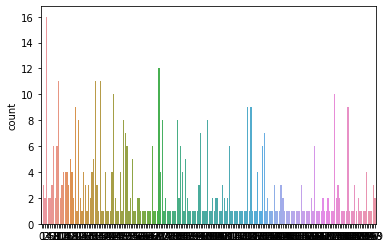

In [539]:
sns.countplot(kmeans.labels_)
plt.show()

In [281]:
# kmeans.cluster_centers_ # 군집 중심점 좌표

In [560]:
print(kmeans.inertia_)

13072.378960122704


In [286]:
# dbscan = DBSCAN(eps=0.3, min_samples=2)
# dbscan.fit(df_total_v2_norm.loc[:, 'Tempo':])
# dbscan.labels_

In [541]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_total_v2_norm.loc[:, 'Tempo':])

In [542]:
pca.explained_variance_ratio_

array([0.130124  , 0.09604518])

In [543]:
np.sum(pca.explained_variance_ratio_)

0.2261691876482857

In [544]:
df_pca_result = pd.DataFrame(pca_result, columns=[f'PCA_component_{i+1}' for i in range(len(pca.components_))])
df_pca_result.head()

,PCA_component_1,PCA_component_2
0,1.041476,-1.672583
1,-2.830605,-2.663727
2,-0.647905,-0.292263
3,-0.580346,-1.510492
4,0.298995,2.417592


In [553]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(df_pca_result)

df_pca_result['Cluster'] = kmeans.labels_

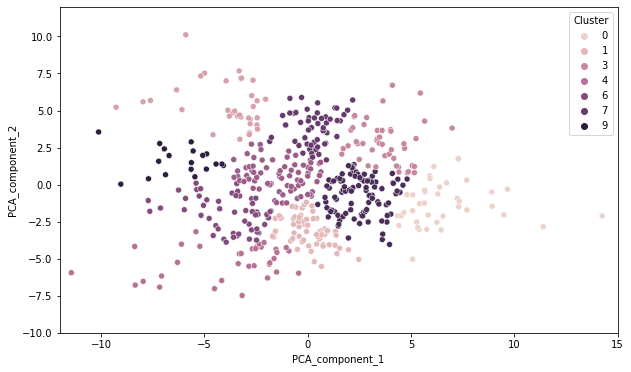

In [554]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_pca_result['PCA_component_1'], y=df_pca_result['PCA_component_2'], hue=df_pca_result['Cluster'])
# plt.xlim(-10000, 25000)
# plt.ylim(-4000, 6000)
plt.xlim(-12, 15)
plt.ylim(-10, 12)
plt.show()

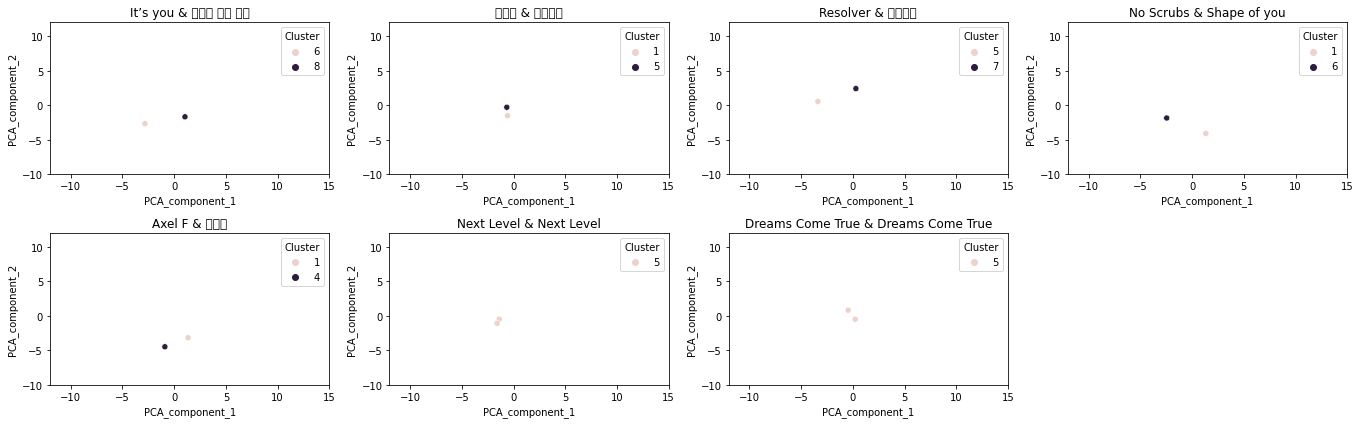

In [555]:
plt.figure(figsize=(19,6))

for i in range(7):
  plt.subplot(2, 4, i+1)
  df = df_pca_result.loc[i*2:i*2+1, :]
  sns.scatterplot(x=df['PCA_component_1'], y=df['PCA_component_2'], hue=df['Cluster'])
  # plt.xlim(-10000, 25000)
  # plt.ylim(-4000, 6000)
  plt.xlim(-12, 15)
  plt.ylim(-10, 12)
  plt.title(f'{df_kmeans_v2.loc[i*2,"Music"].split(" - ")[1]} & {df_kmeans_v2.loc[i*2+1,"Music"].split(" - ")[1]}')

# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

#### 음원 들어보기

In [516]:
df_kmeans_v2.head(14)

,Music,Path,Cluster_kmeans
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,10
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,23
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,10
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,10
4,요시마타 료 - Resolver,/content/drive/MyDrive/ds_study/DL_project2/te...,10
5,FTISLAND - 사랑앓이,/content/drive/MyDrive/ds_study/DL_project2/te...,24
6,TLC - No Scrubs,/content/drive/MyDrive/ds_study/DL_project2/te...,23
7,Ed Sheeran - Shape of you,/content/drive/MyDrive/ds_study/DL_project2/te...,25
8,Harold Faltermeyer - Axel F,/content/drive/MyDrive/ds_study/DL_project2/te...,23
9,싸이 - 챔피언,/content/drive/MyDrive/ds_study/DL_project2/te...,10


In [519]:
df_kmeans_v2[df_kmeans_v2['Cluster_kmeans'] == 23].head()

,Music,Path,Cluster_kmeans
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,23
6,TLC - No Scrubs,/content/drive/MyDrive/ds_study/DL_project2/te...,23
8,Harold Faltermeyer - Axel F,/content/drive/MyDrive/ds_study/DL_project2/te...,23
65,Music_248,/content/drive/MyDrive/ds_study/DL_project2/da...,23
106,Music_395,/content/drive/MyDrive/ds_study/DL_project2/da...,23


In [520]:
ipd.Audio(df_kmeans_v2[df_kmeans_v2['Cluster_kmeans'] == 23].loc[65, 'Path'], rate=44100)

#### GMM

In [523]:
from sklearn.mixture import GaussianMixture

In [558]:
gmm = GaussianMixture(n_components=200, random_state=42)
gmm_labels = gmm.fit_predict(df_total_v2_norm.loc[:, 'Tempo':])

df_gmm_v2 = df_total_v2_norm.loc[:, :'Path']
df_gmm_v2['Cluster_gmm'] = gmm_labels
df_gmm_v2.head(14)

,Music,Path,Cluster_gmm
0,더더 - It’s you,/content/drive/MyDrive/ds_study/DL_project2/te...,2
1,MC몽 - 너에게 쓰는 편지,/content/drive/MyDrive/ds_study/DL_project2/te...,103
2,와이낫 - 파랑새,/content/drive/MyDrive/ds_study/DL_project2/te...,102
3,씨엔블루 - 외톨이야,/content/drive/MyDrive/ds_study/DL_project2/te...,102
4,요시마타 료 - Resolver,/content/drive/MyDrive/ds_study/DL_project2/te...,102
5,FTISLAND - 사랑앓이,/content/drive/MyDrive/ds_study/DL_project2/te...,102
6,TLC - No Scrubs,/content/drive/MyDrive/ds_study/DL_project2/te...,2
7,Ed Sheeran - Shape of you,/content/drive/MyDrive/ds_study/DL_project2/te...,50
8,Harold Faltermeyer - Axel F,/content/drive/MyDrive/ds_study/DL_project2/te...,89
9,싸이 - 챔피언,/content/drive/MyDrive/ds_study/DL_project2/te...,188


In [556]:
gmm = GaussianMixture(n_components=10, random_state=42)
gmm_labels = gmm.fit_predict(df_pca_result)

df_pca_result['Cluster'] = gmm_labels

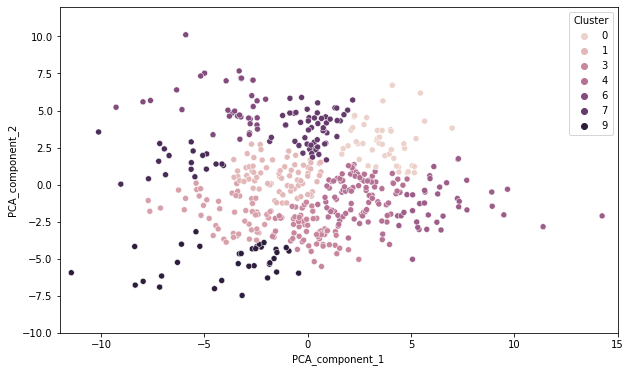

In [557]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_pca_result['PCA_component_1'], y=df_pca_result['PCA_component_2'], hue=df_pca_result['Cluster'])
# plt.xlim(-10000, 25000)
# plt.ylim(-4000, 6000)
plt.xlim(-12, 15)
plt.ylim(-10, 12)
plt.show()

# Part 3. Mel Spectrogram 활용

In [ ]:
# melspectrogram 시각화 함수 정의
def show_melspectrogram(music, sr):
  S = librosa.feature.melspectrogram(y=music, sr=sr)
  S_db = librosa.power_to_db(S, ref=np.max)
  seconds = len(music)/SAMPLING_RATE

  plt.figure(figsize=(15,5))
  librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
  plt.colorbar()
  plt.tight_layout()
  plt.xlabel('time')
  plt.ylabel('Hz')
  plt.xticks(np.arange(0, seconds, seconds//10)) # 좌표간격 설정
  plt.show()

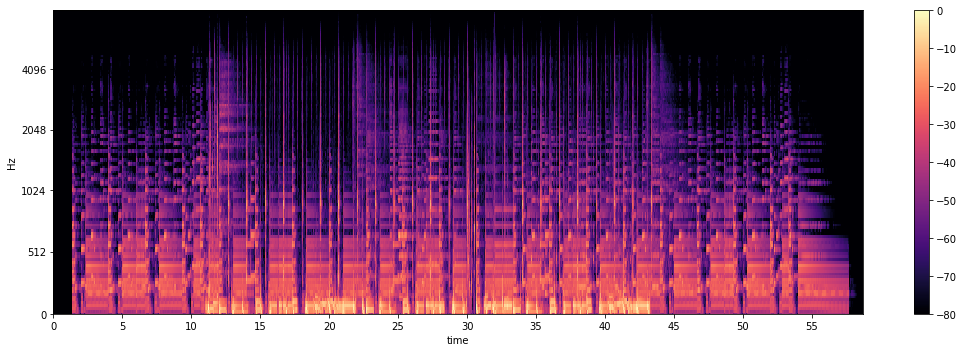

In [ ]:
show_melspectrogram(music, sr)